In [1]:
%load_ext autoreload 
%autoreload 2

import numpy as np
import torch
import matplotlib.pyplot as plt
from fusanet_utils.datasets.simulated import SimulatedPoliphonic
from fusanet_utils.datasets.fusa import FUSA_dataset
from torch.utils.data import ConcatDataset
from tqdm.notebook import tqdm
import yaml
import json

categories = json.load(open('/home/phuijse/Downloads/index_to_name.json'))
model = torch.load('/home/phuijse/Downloads/model.pt')
dataset = SimulatedPoliphonic('..', external=True, mini=False, categories = (categories.values()))
params = yaml.safe_load(open('../experiments/Poliphonic-PANN-sed-no-pretrained/params.yaml'))
fusa_dataset = FUSA_dataset(ConcatDataset([dataset]), feature_params=params["features"])

len(dataset.categories)

33

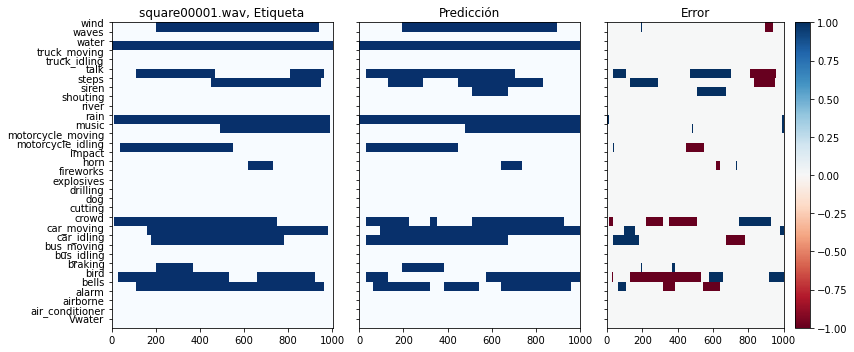

In [2]:
def plot_file_prediction(file_idx: int, th: float=None):
    pred = model.forward(fusa_dataset[file_idx])[0].T.detach().numpy()
    if th is not None:
        pred = pred > th
    label = fusa_dataset[file_idx]['label'].T.numpy()
    fig, ax = plt.subplots(1, 3, figsize=(12, 5), facecolor='w',
                           tight_layout=True, sharex=True, sharey=True)
    ax[0].pcolormesh(label, cmap=plt.cm.Blues, vmin=0, vmax=1)
    ax[0].set_title(f"{fusa_dataset[file_idx]['filename']}, Etiqueta")
    ax[1].pcolormesh(pred, cmap=plt.cm.Blues, vmin=0, vmax=1)
    ax[1].set_title('Predicción')
    cmap = ax[2].pcolormesh((pred - label), cmap=plt.cm.RdBu, vmin=-1, vmax=1)
    fig.colorbar(cmap)
    ax[2].set_title('Error')
    ax[0].set_yticks(range(1, len(categories.values())+1))
    ax[0].set_yticklabels((categories.values()));
    
plot_file_prediction(0, 0.3)

In [3]:
scenarios = {0:'square', 1:'park', 2:'waterfront', 3:'market', 4:'street'}
th = 0.3
places, labels, preds = [], [], []
for sample in tqdm(fusa_dataset):
    places.append([key for key, scene in scenarios.items() if scene in sample['filename']][0])
    preds.append( model.forward(sample)[0].T.detach().numpy() > th)
    labels.append(sample['label'].T.numpy())    
places = np.array(places)

  0%|          | 0/25 [00:00<?, ?it/s]

Por clase para todos los ambientes

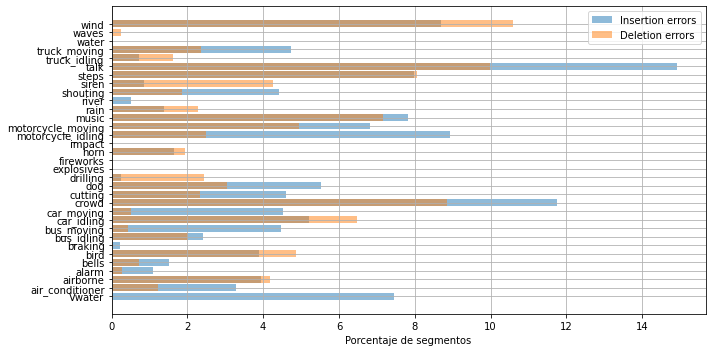

In [4]:
insertions = np.mean(np.stack([np.mean((pred == 1) & (label == 0), axis=1) for pred, label in zip(preds, labels)]), axis=0)
deletions = np.mean(np.stack([np.mean((pred == 0) & (label == 1), axis=1) for pred, label in zip(preds, labels)]), axis=0)

fig, ax = plt.subplots(figsize=(10, 5), facecolor='w',
                       tight_layout=True, sharey=True, sharex=True)
ax.barh(y=list(categories.values()), width=100*insertions, 
        label='Insertion errors', alpha=0.5)
ax.barh(y=list(categories.values()), width=100*deletions,
        label='Deletion errors', alpha=0.5)
ax.legend()
ax.grid()
ax.set_xlabel('Porcentaje de segmentos');

Por ambiente separado por clase:

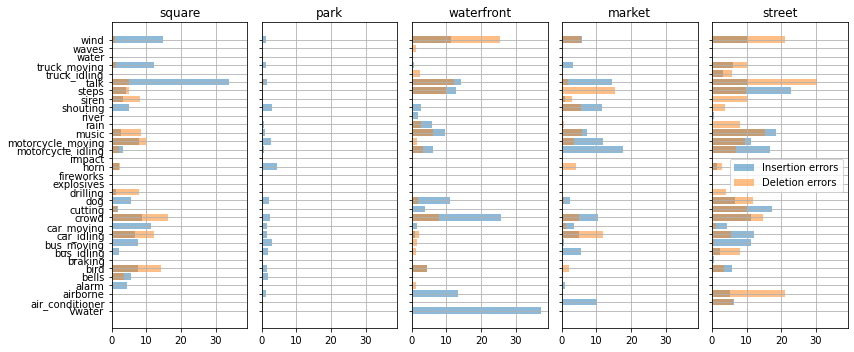

In [5]:
deletions = np.stack([np.mean((pred == 0) & (label == 1), axis=1) for pred, label in zip(preds, labels)])
deletions = np.array([deletions[places == place].mean(axis=0) for place in scenarios.keys()])

insertions = np.stack([np.mean((pred == 1) & (label == 0), axis=1) for pred, label in zip(preds, labels)])
insertions = np.array([insertions[places == place].mean(axis=0) for place in scenarios.keys()])

fig, ax = plt.subplots(1, 5, figsize=(12, 5), facecolor='w',
                       tight_layout=True, sharey=True, sharex=True)  
for ax_, ins, dels, scene in zip(ax, insertions, deletions, scenarios.values()):
    ax_.barh(y=list(categories.values()), width=100*ins, 
        label='Insertion errors', alpha=0.5)
    ax_.barh(y=list(categories.values()), width=100*dels,
            label='Deletion errors', alpha=0.5)
    ax_.set_title(scene)
    ax_.grid()
ax_.legend();

Por ambiente:

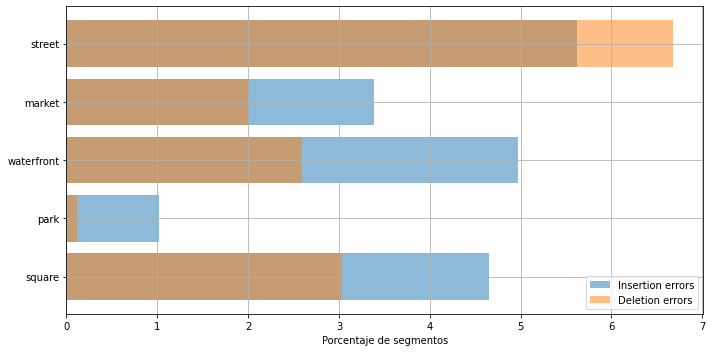

In [6]:
deletions = np.stack([np.mean((pred == 0) & (label == 1), axis=1) for pred, label in zip(preds, labels)])
deletions = np.array([deletions[places == place].mean() for place in scenarios.keys()])

insertions = np.stack([np.mean((pred == 1) & (label == 0), axis=1) for pred, label in zip(preds, labels)])
insertions = np.array([insertions[places == place].mean() for place in scenarios.keys()])

fig, ax = plt.subplots(figsize=(10, 5), facecolor='w',
                       tight_layout=True, sharey=True, sharex=True)
ax.barh(y=list(scenarios.values()), width=100*insertions, 
        label='Insertion errors', alpha=0.5)
ax.barh(y=list(scenarios.values()), width=100*deletions,
        label='Deletion errors', alpha=0.5)
ax.legend()
ax.grid()
ax.set_xlabel('Porcentaje de segmentos');

Por macro clase: